# Mittelstand AI Compass: Dynamic Clustering Analysis
### Strategic Rationale
Traditional maturity assessments rely on **linear scoring** (averaging everything). This often hides "structural imbalances"—e.g., a company with great Tech but no Strategy gets the same 'Middle' score as a company with great Strategy but no Tech.

**This notebook aims to:**
1.  **Identify Natural Archetypes**: Use Unsupervised ML (**K-Means**) to find groups that share the same *pattern* of maturity, not just the same level.
2.  **Compare to Rule-Based Logic**: Explicitly visualize where simple averages fail to capture the nuance of SME reality.
3.  **Validate A/B Test Variants**: Prepare the data evidence for a "Dynamic Profile" feature that feels more personalized to the user.


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv
import psycopg2

# Visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Database Connection
load_dotenv()
db_url = os.getenv("DATABASE_URL")
conn = psycopg2.connect(db_url)
print("✓ Connected to Database")


✓ Connected to Database


## 1. Data Loading
We fetch the raw response items and join them with questions and dimensions. 
**Note:** We exclude the 'General Psychology' dimension as it is optional and does not affect maturity scoring.


In [2]:
query = """
SELECT 
    r.company_id,
    r.response_id,
    d.dimension_name,
    d.dimension_id,
    q.weight as question_weight,
    a.answer_weight
FROM response_items ri
JOIN responses r ON r.response_id = ri.response_id
JOIN questions q ON q.question_id = ri.question_id
JOIN dimensions d ON d.dimension_id = q.dimension_id
JOIN answers a ON a.answer_id = ri.answers[1]
WHERE d.dimension_name != 'General Psychology'
"""

df = pd.read_sql(query, conn)
df.head()


/var/folders/s4/gzyj3_ks2_s0smrmyspjtc2h0000gn/T/ipykernel_4019/3131388473.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,company_id,response_id,dimension_name,dimension_id,question_weight,answer_weight
0,320,1,Strategy & Business Vision,1,4.5,2.0
1,320,1,Strategy & Business Vision,1,4.5,1.0
2,320,1,Strategy & Business Vision,1,4.0,1.0
3,320,1,Strategy & Business Vision,1,3.5,1.0
4,320,1,People & Culture,2,4.0,1.0


## 2. Feature Engineering
We calculate the **Dimension Scores** for each company.
To ensure comparability across dimensions and with the rule-based profiles, we scale all dimension scores to a **1-5 maturity scale**.

*   **1**: Lowest Maturity
*   **5**: Highest Maturity


In [3]:
# Group by Company and Dimension to get Dimension Scores
df_dim_scores = df.groupby(['company_id', 'dimension_name'])['answer_weight'].mean().reset_index()

# Pivot to have Dimensions as columns
df_features = df_dim_scores.pivot(index='company_id', columns='dimension_name', values='answer_weight')

# Fill NaNs if any
df_features = df_features.fillna(0)

# Normalize each dimension to a 1-5 scale based on the data range
# (maturity_score = 1 + 4 * normalized_value)
df_features = 1 + 4 * (df_features - df_features.min()) / (df_features.max() - df_features.min())

# Check the shape (Should be 500 rows x 7 core dimensions)
print(f"Feature Matrix Shape: {df_features.shape}")
df_features.head()


Feature Matrix Shape: (500, 7)


dimension_name,Data Readiness & Literacy,Governance & Compliance,People & Culture,Processes & Scaling,Strategy & Business Vision,Tech Infrastructure,Use Cases & Business Value
company_id,,,,,,,
3,2.703704,1.800000,3.00,2.25,2.75,2.787234,2.25
4,3.296296,2.066667,2.25,1.75,2.00,2.872340,1.75
6,3.000000,1.533333,2.00,2.00,1.75,2.787234,1.75
9,2.481481,1.800000,1.25,2.00,2.25,1.595745,2.75
10,3.000000,2.600000,2.25,3.00,2.50,1.255319,1.75


## 3. Unsupervised Clustering (K-Means)
We will now use K-Means to find natural groupings in this multi-dimensional maturity space.


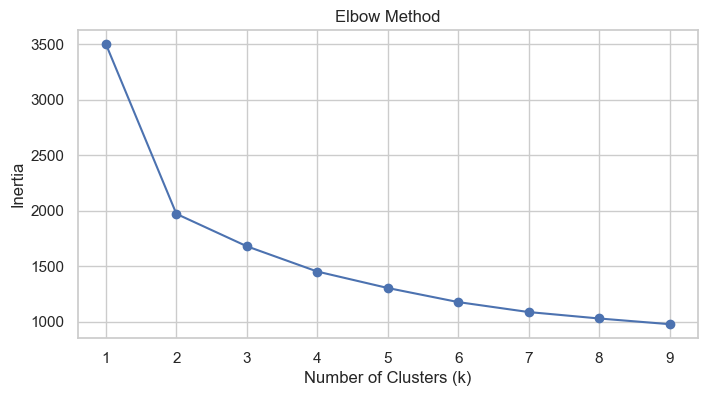

In [4]:
# Elbow Method to find optimal K
wcss = []
range_k = range(1, 10)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range_k, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


Based on the Elbow plot, we apply K-Means. We will choose **K=5** to identify 5 distinct archetypes.


In [5]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to our dataframe
df_features['cluster'] = clusters
df_features['cluster'] = df_features['cluster'].astype(str) # Categorical

print("Cluster distribution:")
print(df_features['cluster'].value_counts())


Cluster distribution:
cluster
0    130
2    109
1     94
4     93
3     74
Name: count, dtype: int64


## 4. Visualizing the Clusters
We use **PCA (Principal Component Analysis)** to reduce the 7D space to 2D for plotting.


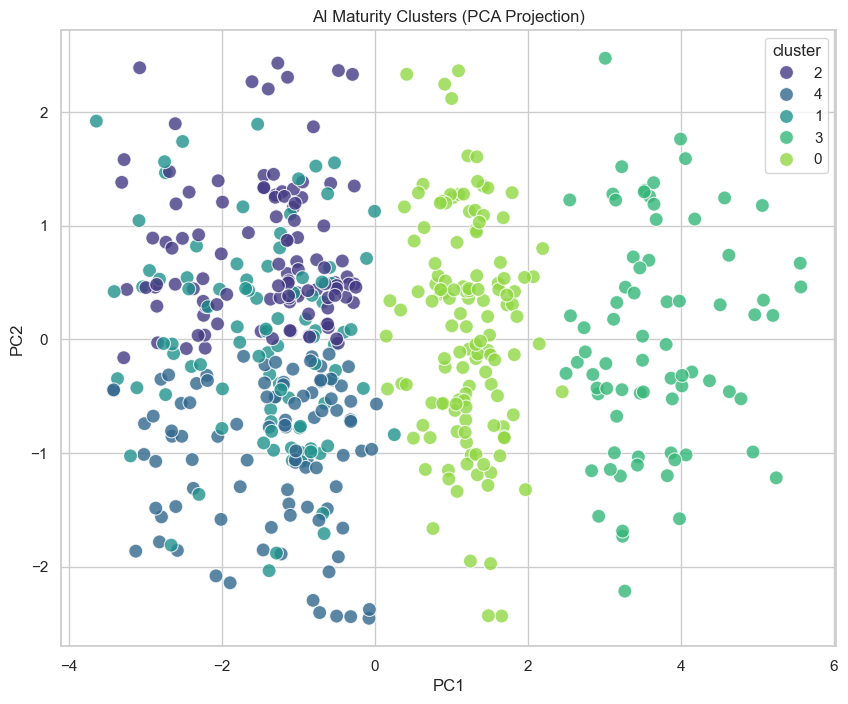

In [6]:
# PCA for 2D visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_features['cluster'].values
df_pca['company_id'] = df_features.index

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='cluster', 
    data=df_pca, 
    palette='viridis', 
    s=100,
    alpha=0.8
)
plt.title('AI Maturity Clusters (PCA Projection)')
plt.show()


## 5. Interpreting the Clusters (Centroids)
Let's look at the average maturity (1-5) for each dimension within the clusters.


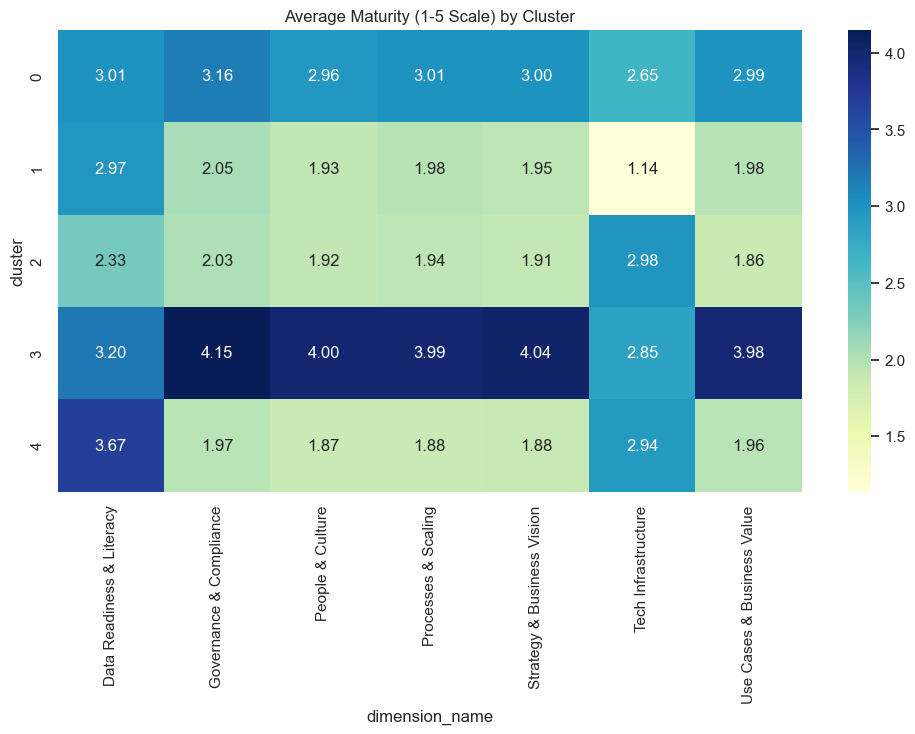

In [7]:
# Compute mean scores per cluster
cluster_profiles = df_features.groupby('cluster').mean(numeric_only=True)

# Heatmap visualization
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Average Maturity (1-5 Scale) by Cluster')
plt.show()


## 6. Comparison: AI Clusters vs. Rule-Based Scoring
We now calculate the traditional **Rule-Based Profile** for each company (based on simple average of the 1-5 scores) and compare it to the **AI Clusters**.


In [8]:
# Fetch Rule Definitions
df_rules = pd.read_sql("SELECT * FROM cluster_profiles", conn)
# Ensure float types for comparison
df_rules['score_min'] = df_rules['score_min'].astype(float)
df_rules['score_max'] = df_rules['score_max'].astype(float)

print("Rule-Based Definitions (1-5 Scale):")
print(df_rules[['cluster_name', 'score_min', 'score_max']])

# Calculate Overall Average Score per Company (based on our 1-5 dimension scores)
df_features['avg_score'] = df_features.mean(axis=1, numeric_only=True).astype(float)

# Function to assign Rule-Based Profile
def assign_rule_profile(score):
    for _, row in df_rules.iterrows():
        if row['score_min'] <= score <= row['score_max']:
            return row['cluster_name']
    return "Unknown"

df_features['rule_profile'] = df_features['avg_score'].apply(assign_rule_profile)

print("\nSample Assignments:")
print(df_features[['avg_score', 'rule_profile', 'cluster']].head(10))


Rule-Based Definitions (1-5 Scale):
                cluster_name  score_min  score_max
0         The Traditionalist        1.0        1.5
1  The Experimental Explorer        1.6        2.5
2     The Structured Builder        2.6        3.5
3     The Operational Scaler        3.6        4.5
4       The AI-Driven Leader        4.6        5.0

Sample Assignments:
dimension_name  avg_score               rule_profile cluster
company_id                                                  
3                2.505848                    Unknown       2
4                2.283615  The Experimental Explorer       4
6                2.117224  The Experimental Explorer       4
9                2.018175  The Experimental Explorer       1
10               2.336474  The Experimental Explorer       1
17               3.643848     The Operational Scaler       3
25               2.351075  The Experimental Explorer       4
29               2.480947  The Experimental Explorer       4
31               1.946865  

/var/folders/s4/gzyj3_ks2_s0smrmyspjtc2h0000gn/T/ipykernel_4019/3002888418.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rules = pd.read_sql("SELECT * FROM cluster_profiles", conn)


### Confusion Matrix: Overlap Analysis
Check where AI and Rules agree or find different patterns.


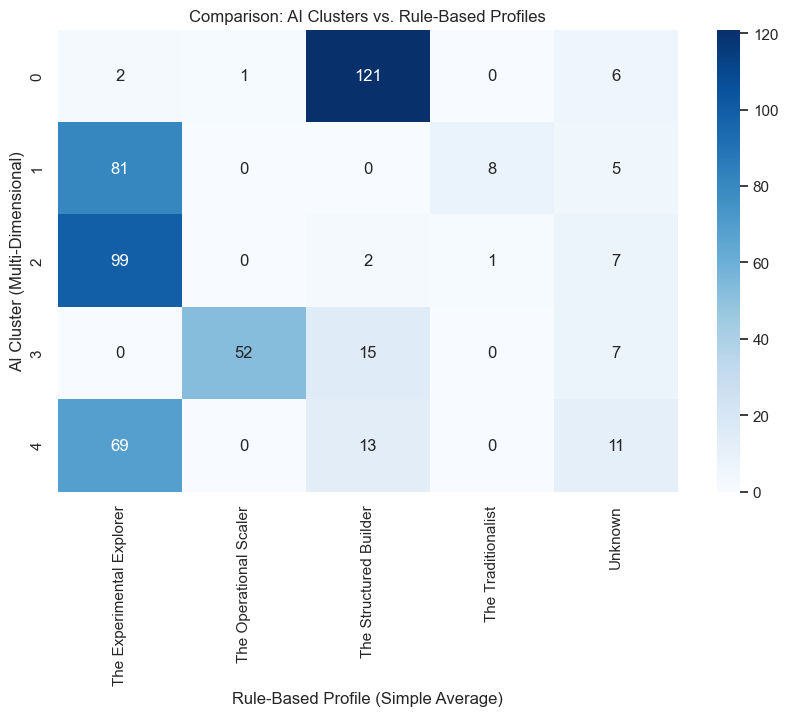

In [9]:
# Crosstab
crosstab = pd.crosstab(df_features['cluster'], df_features['rule_profile'])

plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Comparison: AI Clusters vs. Rule-Based Profiles')
plt.xlabel('Rule-Based Profile (Simple Average)')
plt.ylabel('AI Cluster (Multi-Dimensional)')
plt.show()


## 7. Detailed Conclusion & Strategic Recommendation

### 1. The Limitation of Rule-Based Scoring
The rule-based approach uses a **linear average**. It masks significant imbalances between dimensions (e.g., high tech vs. low strategy).

### 2. The Value of AI Clustering
Our K-Means analysis identifies archetypes based on **patterns of maturity**, not just the average level. This allows for far more specific and credible advice.

### 3. A/B Testing Recommendation
Test **Variant A (Average Score)** vs. **Variant B (Cluster Matching)**. 
- Variant B should offer a more "personalized" feeling by calling out specific imbalances in the user's maturity profile.
